## Task 12 - Capstone

by Chris S

In [457]:
# table manipulation
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# sci-kit learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# clustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# read and view data
df = pd.read_csv("UsArrests.csv",index_col='City')
print(df.shape)
df.head()

(50, 4)


,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.200,236,58,21.200
Alaska,10.000,263,48,44.500
Arizona,8.100,294,80,31.000
Arkansas,8.800,190,50,19.500
California,9.000,276,91,40.600


Why is the index "city" when it is clearly states?

This will be remedied.

In [458]:
# fix city -> state
df.index.name = "State"

# show info
df.info()
# all numeric data types

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


### NB - Data description:
The data is described as follows:

    "This data set contains statistics, in arrests per 100,000 residents,
    for assault, murder, and rape in each of the 50 US states in 1973. 
    Also given is the percent of the population living in urban areas.”

We have 50 data points (rows) each with 4 features.

Variables scaled differently (per 100,000 and % (per 100)) could give weighting issues later on.
Will keep this in mind.

In [459]:
# show stats

# use pandas describe function to get stats
stats = df.describe()
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

# show all but count
my_stats = stats.drop(index="count").transpose()
my_stats

,mean,std,min,25%,50%,75%,max
Murder,7.79,4.36,0.80,4.08,7.25,11.25,17.40
Assault,170.76,83.34,45.00,109.00,159.00,249.00,337.00
UrbanPop,65.54,14.47,32.00,54.50,66.00,77.75,91.00
Rape,21.23,9.37,7.30,15.07,20.10,26.18,46.00


In [460]:
# we saw 0 non-null from info, but still, quick missing data check
missing = df.isnull().sum()
missing

Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

#### Scaling
As expected, Assault has significantly higher values than all others. There is a wide range between highest (Assault) and lowest (Murder) values for all stats. 

Data should be scaled to prevent this single feature dominating.

#### Distribution
See below to view the distribution of each feature. I do this to see if there are any strange distribution patterns that point to outliers.

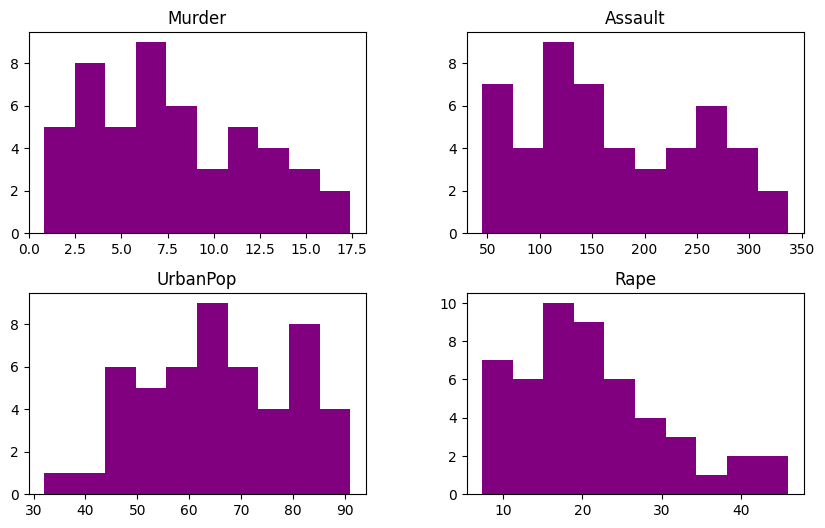

In [461]:
# view distribution for each feature

# histograms
histograms = df.hist(color='purple', grid=False, figsize=(10, 6))
plt.show()

UrbanPop is roughly normally distributed. Others are less so, but lack sigificant outliers. 
Assault has an interesting double-peak (~120 and ~250).

#### Correlation Heatmap

I use a correlation heatmap to determine strong positive/negative correlations and near-zero correlation feature pairs.

<Axes: >

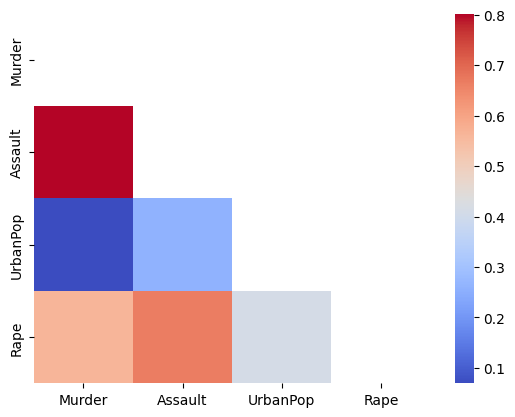

In [462]:
# correlate
corr_df = df.corr()

# show (lower triangle) heatmap
trianlge_mask=np.triu(np.ones(corr_df.shape))
sns.heatmap(corr_df, mask=trianlge_mask, cmap="coolwarm")

Interestingly there is little correlation between UrbanPop and Murder. Anecdotally one might presume higher urban population leads to higher opportunity/risk of violent crime. 

#### Principal Component Analysis

I will use PCA to determine if any features can/should be dropped. It is possible that positive correlations between Assault and Murder especially, but also assault-murder-rape could allow for some dimensional reduction.

In [463]:
# first, retain lists of features and indices for later reference
features = df.columns.values
states = df.index.values

print("features: ", features)
print("indices: ", states)

features:  ['Murder' 'Assault' 'UrbanPop' 'Rape']
indices:  ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


In [464]:
# do initial pca fit
pca = PCA()
X = df.values
X_trans = pca.fit_transform(X)

# make dataframe
np.set_printoptions(precision=2)
df_pca = pd.DataFrame(X_trans)
df_pca.head(2)

,0,1,2,3
0,64.80,11.45,-2.49,2.41
1,92.83,17.98,20.13,-4.09


In [465]:
# PCA biplot - PCA scatter + PCA loading plots
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = states[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

Using the biplot to determine which features as the most impactful. The longer the line, the greater the importance.

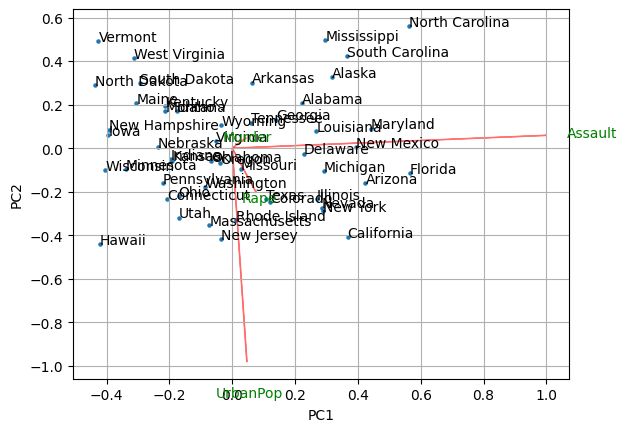

In [466]:
biplot(X_trans[:,0:2], np.transpose(pca.components_[0:2, :]), features, states)
plt.show()

It seems clear that UrbanPop and Assault are the most important features *(unscaled)*

In [467]:
# numerically defined feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) # now 3dp ""%.3f"

# only care about absolute values 
pc1 = abs(pca.components_[0])
pc2 = abs(pca.components_[1])

# feature important dataframe
feat_df = pd.DataFrame()
feat_df["Features"] = features
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


It is not particluarly close. First principle component's most important feature is Assault. PC2 most important feature is UrbanPop.

#### Standardise the data!!!

Must scale the data to ensure that some factors do not unduly override others purely because of their absolute values.

In [468]:
# fit to standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_scaled = PCA()
X_scaled_transformed = pca_scaled.fit_transform(X_scaled)

df_scaled_pca = pd.DataFrame(X_scaled_transformed)
df_scaled_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


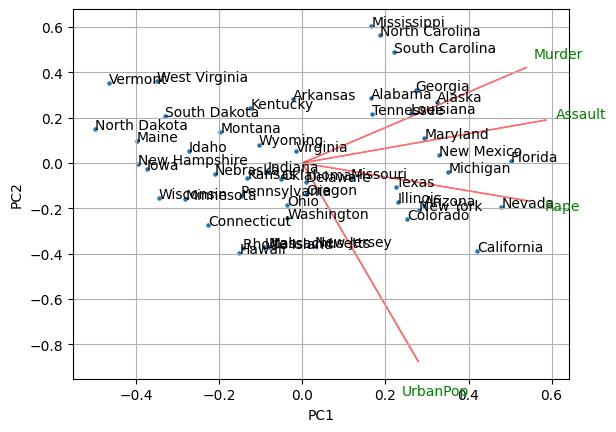

In [469]:
# fit new biplot
biplot(X_scaled_transformed[:,0:2], np.transpose(pca_scaled.components_[0:2, :]), features, states)
plt.show()

Now the weightings seem much more even. All vectors point to the right, indicating a positive correlation with PC1.

In [470]:
# only care about absolute values 
pc1_s = abs(pca_scaled.components_[0])
pc2_s = abs(pca_scaled.components_[1])
pc3_s = abs(pca_scaled.components_[2])


# feature important dataframe
scaled_feat_df = pd.DataFrame()
scaled_feat_df["Features"] = features
scaled_feat_df["PC1 Importance"] = pc1_s
scaled_feat_df["PC2 Importance"] = pc2_s
scaled_feat_df["PC3 Importance"] = pc3_s

scaled_feat_df

,Features,PC1 Importance,PC2 Importance,PC3 Importance
0,Murder,0.536,0.418,0.341
1,Assault,0.583,0.188,0.268
2,UrbanPop,0.278,0.873,0.378
3,Rape,0.543,0.167,0.818


Things are more complicated after scaling features. 


- Excluding UrbanPop, PC1 has equal weights of importance.
- UrbanPop is clearly the most important PC2 feature. 
- Extending the graph to show PC3, we see that Rape is the most important PC3 feature.

The PC1 result tallies with the correlation between Murder, Assault and Rape.


#### Cumulative variance plots

In order to perform dimensionality reduction, we need to know how many principal components are necessary to paint a (mostly) complete picture.

Text(0.5, 1.0, 'Cumulative Explained Variance')

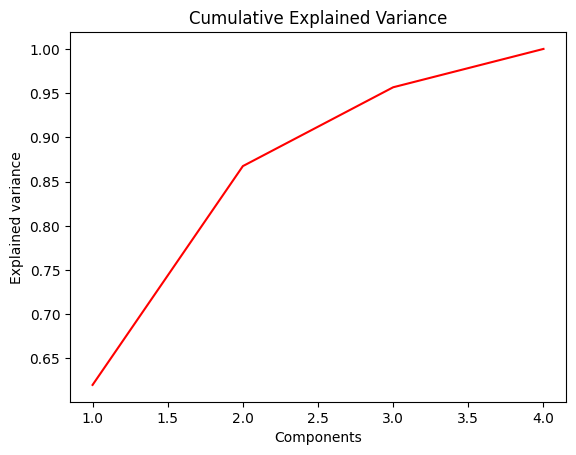

In [471]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca_scaled.explained_variance_ratio_ )+1),
         np.cumsum(pca_scaled.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

[0.62 0.25 0.09 0.04]


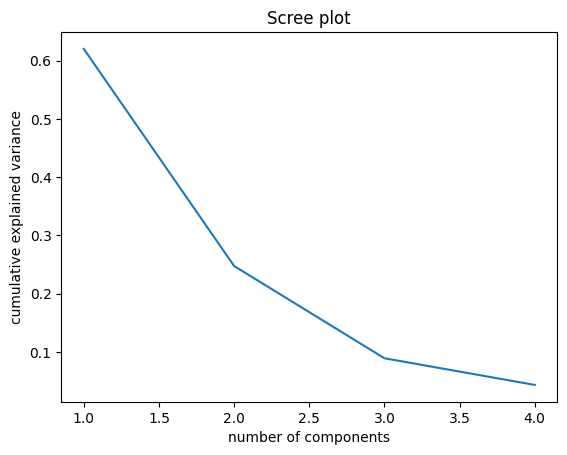

In [472]:
# Scree plot
print(pca_scaled.explained_variance_ratio_)
plt.plot(range(1,len(pca_scaled.explained_variance_ratio_ )+1),
        pca_scaled.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

Scree and CEV plots show that PC1 accounts for 60% of the variace, PC2 approx 25% and PC3 around 10%. 

- *3 components explain approx 95% of the variance of the the full feature set.*

- By selecting three components, I have achieved marginal dimensionality reduction. 

- I *could* reduce it to two with an explained variance of >85%


A data set with greater number of features may have been reduced by a greater proportion.

In [473]:
# create df using first 3 pca
pca_df = pd.DataFrame(X_scaled_transformed[:,0:3], index = df.index)
pca_df.head()

,0,1,2
State,,,
Alabama,0.986,1.133,-0.444
Alaska,1.950,1.073,2.040
Arizona,1.763,-0.746,0.055
Arkansas,-0.141,1.120,0.115
California,2.524,-1.543,0.599


In [474]:
# new 'X' array
X_red = pca_df.values
X_red.shape

(50, 3)

#### Heirarchical clustering

Using dendrograms to investigate clustering of the data.

(1225,)


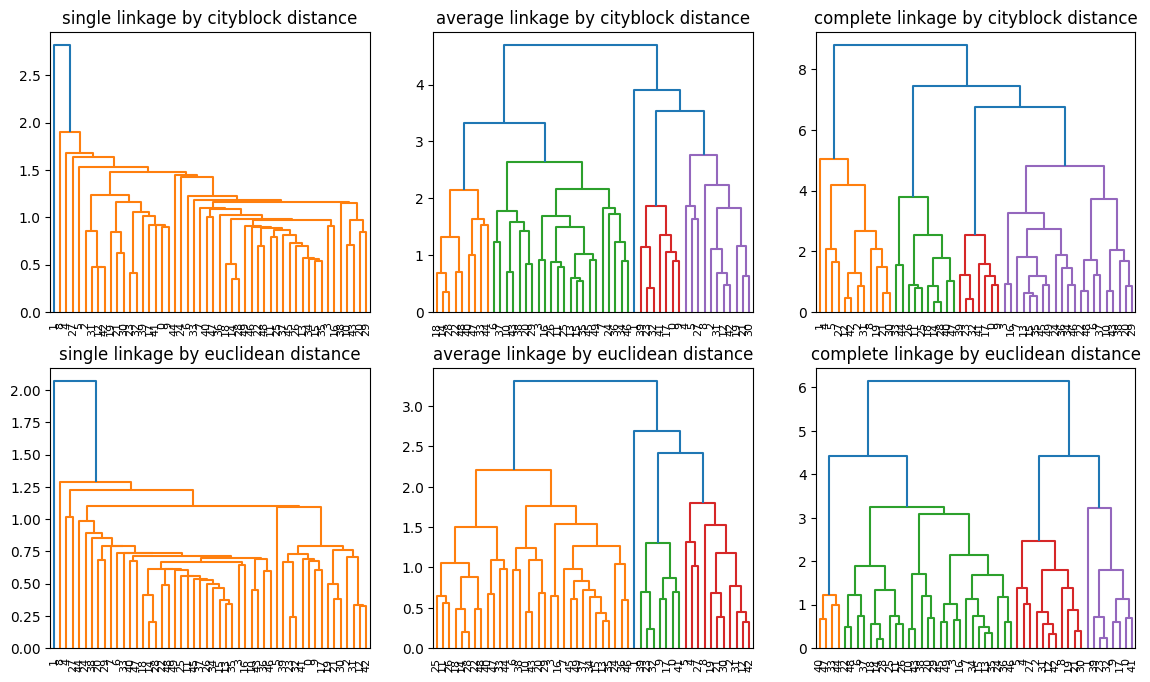

In [475]:
# re-using my work from task 9 here, try both cityblock and euclidean distance metrics
city_dist = pdist(X_red, 'cityblock')
print(city_dist.shape)
euclid_dist = pdist(X_red, 'euclidean')
distances = [city_dist, euclid_dist]

# single average and complete linkages
linkage_types = ['single', 'average', 'complete']

# plot all four outputs
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,8))

# swapped distance-linkage for loops vs task 9 to account for linkage types being columns - for wide (not tall) graph
for i, dist in enumerate(distances):
    for j, l in enumerate(linkage_types):
            dendrogram(linkage(dist, method=l), ax=axes[i, j])
            d = "cityblock" if i==0 else "euclidean"
            axes[i, j].set(title="{} linkage by {} distance".format(l, d))

Complete linkage seems to produce a well-delineated clustering result.

Both cityblock and euclidean seem to work, but the first cluster branch/leaf of the euclidean result (orange) seems tiny, although it is significantly distanced from the closest branch.

#### Look more closely at complete-cityblock result:

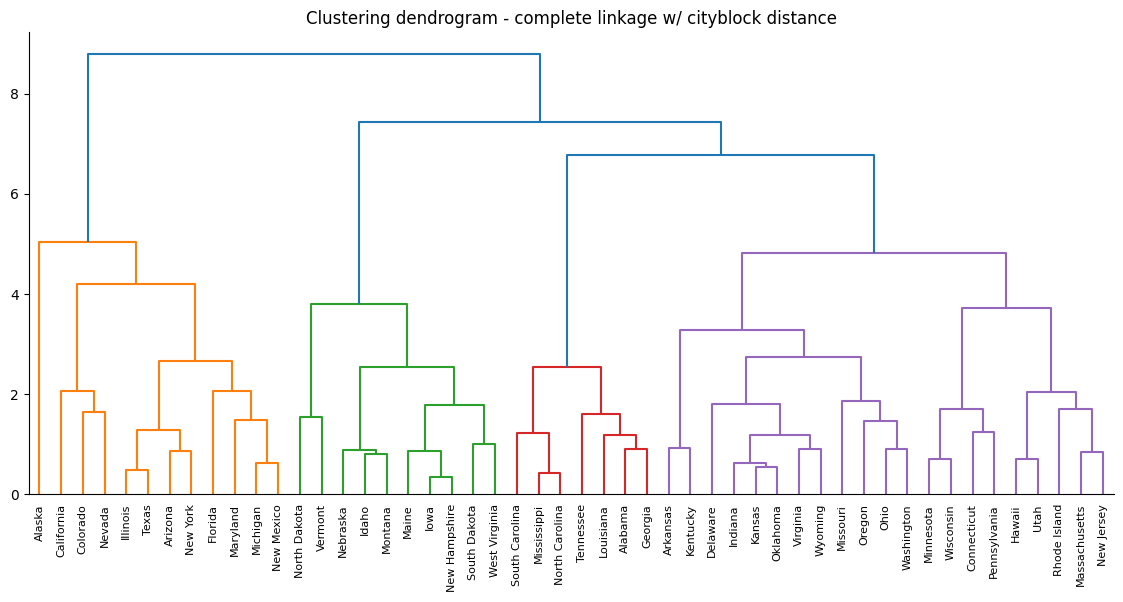

In [476]:
# plot single dendrogram city-complete
fig = plt.figure(figsize=(14,6))
dendrogram(linkage(city_dist, method="complete"), labels=pca_df.index)
plt.title("Clustering dendrogram - complete linkage w/ cityblock distance")
sns.despine()

#### Agglomerative Clustering

I will look at three linkage types and see what kind of clustering is generated.

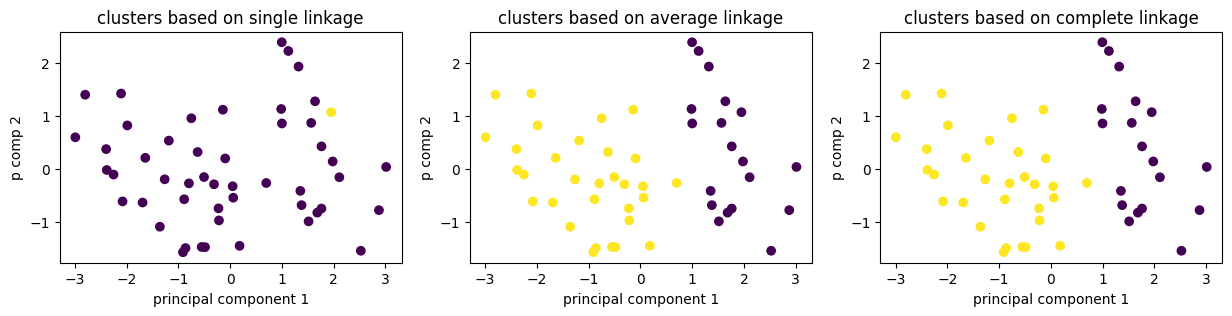

In [477]:
# use x,y shorthand for axes we will use to display 
x, y = X_red[:,0], X_red[:,1]

# distance metrics
plt.figure(figsize=[15,3])

for i, l in enumerate(linkage_types):
  plt.subplot(1, 3, i+1)
  
  cluster = AgglomerativeClustering(metric='euclidean', linkage=l)
  cluster.fit_predict(X_red)

  # plot the sacatter
  ax = plt.scatter(x, y, c=cluster.labels_)
  
  plt.title('clusters based on {} linkage'.format(l))
  plt.xlabel('principal component 1')
  plt.ylabel('p comp 2')

# We observe the same output with both average and complete linkage.

We observe the same output with both average and complete linkage.

#### We can use the Dendrogram work to inform our AgglomerativeClustering
    
    use K=4, complete linkage and cityblock distance.

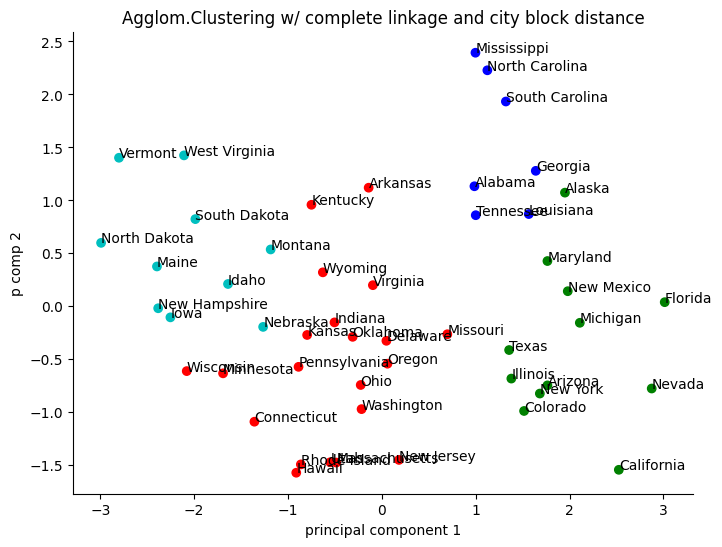

In [478]:
# set K = 4 as in the dendrogram
K = 4

def show_agglom_cluster(index=states, ax=None):
    """display agglom cluster graph, option to pass axis to allow acting as subplot"""
    # precomputed metric allows use of distance at fit stage
    cluster = AgglomerativeClustering(n_clusters=K, metric="precomputed", linkage="complete")

    # must fit square distance matrix
    cluster.fit_predict(squareform(city_dist))

    if ax is None: # for standalone
        # plot clusters
        fig, ax = plt.subplots(figsize=(8, 6))

    # set same colors as KMeans for later comparison... but then realise that the labels won't match..
    colours = 'rbgcmy'

    # remap...
    # r=g, b=r, g=c, c=b
    colours = 'grcb'

    # use unscaled values
    ax.scatter(x, y, c=[colours[l] for l in cluster.labels_])
    ax.set(title="Agglom.Clustering w/ complete linkage and city block distance",
           xlabel="principal component 1",
           ylabel="p comp 2"
           )

    # annotate states
    for i in range(0,len(x)):
        txt = index[i]
        ax.annotate(txt, (x[i], y[i]))
        
    sns.despine()

show_agglom_cluster()

This results in some interesting clusters. 

It looks like two lower clusters include most of the "rich" and populous states in the US.

#### KMeans clustering

Kmeans clustering is interesting because you must set the number of clusters yourself.

As the dendrograms produced 4 clusters and to match the above Agglom. Clustering attempt, I will try K=4.

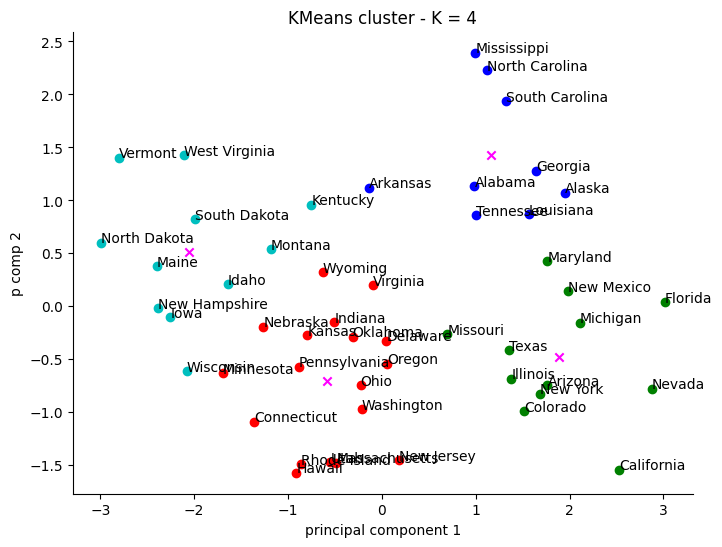

In [479]:
def show_kmeans(show_centers=True, index=states, ax=None):
    """display kmeans graph, option to pass axis to allow acting as subplot"""
    # KMeans - n_init must be defined or error!
    kmeans = KMeans(n_clusters=K, init='k-means++', random_state=1, n_init="auto")
    y_pred = kmeans.fit_predict(pca_df)
    cent = kmeans.cluster_centers_
    colours = 'rbgcmy'

    if ax is None:
        # plot clusters
        fig, ax = plt.subplots(figsize=(8, 6))

    for i in range(K):
        ax.scatter(x[y_pred == i], y[y_pred == i], c = colours[i])
        if show_centers is True:
            ax.scatter(kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1], marker='x', c = 'magenta')

    # annotate
    for i in range(0,len(x)):
        txt = index[i]
        ax.annotate(txt, (x[i], y[i]))

    ax.set(title="KMeans cluster - K = {}".format(K),
            xlabel="principal component 1",
            ylabel="p comp 2"
           )
    sns.despine()

show_kmeans()

### KMeans and Agglomerative Clustering side by side

These look very similar. I want to observe both together, with less visual clutter from the full state names.

In [480]:
# import csv of a state post code table I put together from a table online
post_df = pd.read_csv("Us_state_post_codes.csv", index_col="State")
print(post_df.shape)
post_df.head()

(50, 1)


,Postal
State,
Alabama,AL
Alaska,AK
Arizona,AZ
Arkansas,AR
California,CA


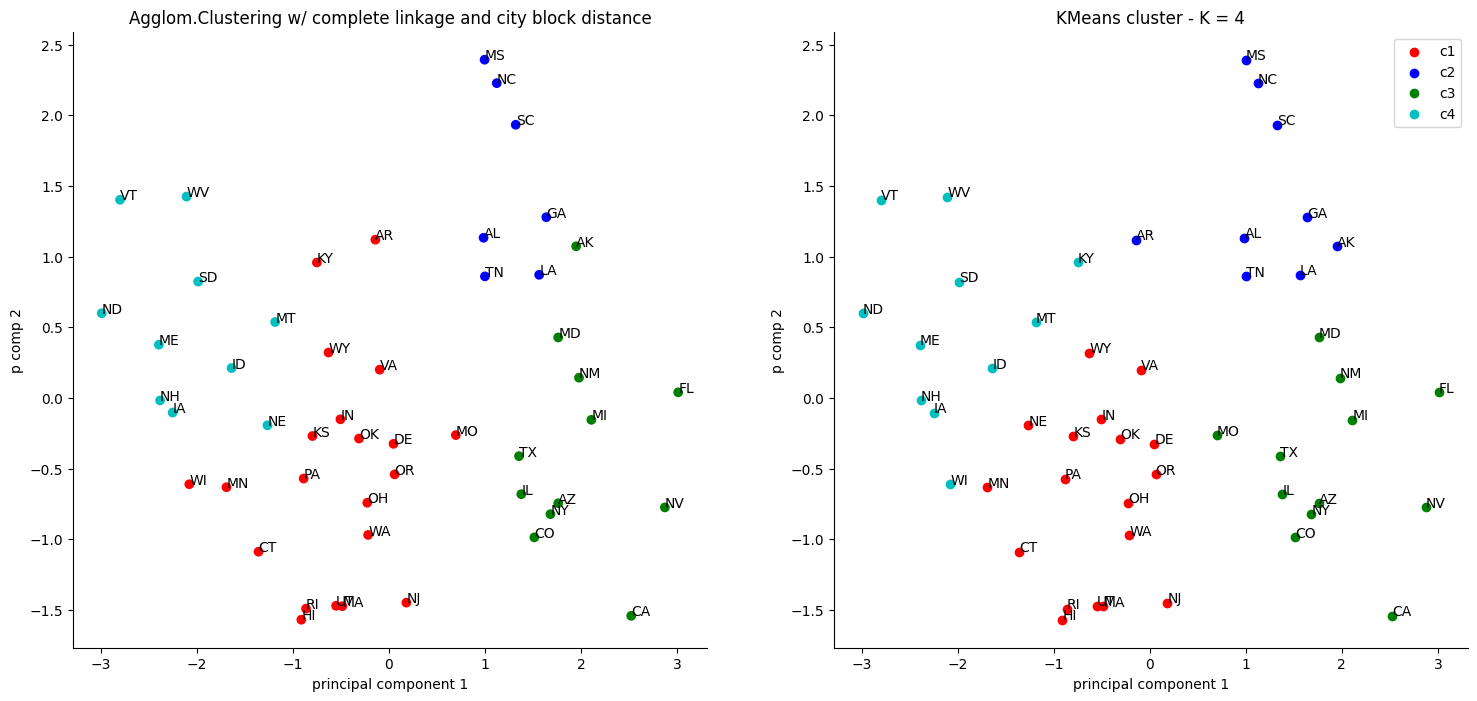

In [481]:
# confirmed they are both alphabetical and same shape, will now use postal code in place of full state name in visualisations
postal = post_df["Postal"].values

# plot both on same subplot
fig, axs = plt.subplots(1, 2, figsize=(18,8))
show_agglom_cluster(index=postal, ax=axs[0])
show_kmeans(show_centers=False, index=postal, ax=axs[1])

# show arbitrary legend
plt.legend(labels=["c1", "c2", "c3", "c4"])

### Conclusion
Having changed the colour mapping of one clustering method to match the other, we can see that the clusters are very similar. There are a few outliers/overlap points where states are in different clusters.

For example, Wisconsin (WI) is in c1 cluster (red) in Agglomerative Clustering model, but c4 (cyan) in the KMeans model.

I am surprised that the two models were so similar.


Cluster 2 (blue) includes a lot of geographically similar states. Georgia, Louisiana, Alabama, Tenessee, North & South Carolina, Mississippi cover a large contigious swathe from south central to the south-east coast. One could presume there is a geographical feature that has an effect, or a different independent feature similarity that these neighbouring states share.

Having other features to compare would make for interesting analysis. For example, median income, political leaning, gun ownership, education levels etc.

In [482]:
# add cluster info to original dataframe, use only Kmeans for simplicity
kmeans = KMeans(n_clusters=K, init='k-means++', random_state=1, n_init="auto")
y_pred = kmeans.fit_predict(pca_df)

group_list = []
for i in y_pred:
    group_list.append(i+1)

#print(group_list)

# add new columns
df["ClusterGroup"] = group_list
df.sample(10)

,Murder,Assault,UrbanPop,Rape,ClusterGroup
State,,,,,
Nevada,12.200,252,81,46.000,3
Wisconsin,2.600,53,66,10.800,4
Alabama,13.200,236,58,21.200,2
New Mexico,11.400,285,70,32.100,3
Rhode Island,3.400,174,87,8.300,1
Colorado,7.900,204,78,38.700,3
West Virginia,5.700,81,39,9.300,4
Montana,6.000,109,53,16.400,4
Delaware,5.900,238,72,15.800,1


#### Post-conclusion

Out of interest I went back and ran the notebook using only 2 principal components. This resulted in varied dendrogram output that hinted at 2 or 3 clusters. The third was always small.

Using K=3 and 2-feature pca, the outputs of AgglomerativeClustering and KMeans were very different from each other.

This task will be synced to my github account.

### Bibliography
- PCA biplot graph: https://ostwalprasad.github.io/machine-learning/PCA-using-python.html
- passing axes as parameters to allow standalone or subplot graphs: https://stackoverflow.com/questions/50279217/adding-figures-to-subplots
- state postal abbreviations: https://www.50states.com/abbreviations.htm